In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.multioutput import MultiOutputRegressor


In [12]:
# Load datasets
train_data = pd.read_csv('scaled_train_data.csv')
test_data = pd.read_csv('scaled_test_data.csv')

# Drop raw categorical variables
train_data.drop(columns=['Area', 'Soil group', 'Land class', 'Soil type'], axis=1, inplace=True)
test_data.drop(columns=['Area', 'Soil group', 'Land class', 'Soil type'], axis=1, inplace=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pH                           328 non-null    float64
 1   SOC                          328 non-null    float64
 2   Nitrogen                     328 non-null    float64
 3   Potassium                    328 non-null    float64
 4   Phosphorus                   328 non-null    float64
 5   Sulfur                       328 non-null    float64
 6   Boron                        328 non-null    float64
 7   Zinc                         328 non-null    float64
 8   Sand                         328 non-null    float64
 9   Silt                         328 non-null    float64
 10  Clay                         328 non-null    float64
 11  SOC mean by Soil group       328 non-null    float64
 12  Boron mean by Soil group     328 non-null    float64
 13  Zinc mean by Soil gr

In [13]:
# Prepare training data
X_train = train_data.drop(columns=['SOC', 'Boron', 'Zinc'])
y_train = train_data[['SOC', 'Boron', 'Zinc']]

# Prepare testing data
X_test = test_data.drop(columns=['SOC', 'Boron', 'Zinc'])
y_test = test_data[['SOC', 'Boron', 'Zinc']] 

# Workflow Summary
### Initial Testing:
Test all models with default hyperparameters.
Evaluate and rank models based on their performance metrics.
### Random Search:
Select the top model(s) and perform Random Search for hyperparameters.
Narrow down to a smaller range of hyperparameters.
### Grid Search:
Perform Grid Search for the best hyperparameters using the selected models.
Choose the best model for each target feature.
### Final Evaluation:
Train the final model(s) on the entire training dataset.


In [14]:
# Define models
models = {
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'DecisionTree': MultiOutputRegressor(DecisionTreeRegressor()),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(random_state=0)),
    'AdaBoost': MultiOutputRegressor(AdaBoostRegressor(random_state=0)),
    'Bagging': MultiOutputRegressor(BaggingRegressor(random_state=0)),
    'KNeighbors': MultiOutputRegressor(KNeighborsRegressor()),
    'SVR': MultiOutputRegressor(SVR()),
    'XGB': MultiOutputRegressor(XGBRegressor(random_state=0))
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Store results
results = {}
feature_importances = {}

# Cross-validation on training data
for model_name, model in models.items():
    fold_metrics = {'RMSE': [], 'MAE': [], 'R²': []}
    fold_importances = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        # Split data into training and validation sets for this fold
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on validation set
        y_val_pred = model.predict(X_val_fold)

        # Evaluate performance
        fold_metrics['RMSE'].append(mean_squared_error(y_val_fold, y_val_pred, squared=False))
        fold_metrics['MAE'].append(mean_absolute_error(y_val_fold, y_val_pred))
        fold_metrics['R²'].append(r2_score(y_val_fold, y_val_pred))

        # Permutation importance for each target
        for target_idx, target_name in enumerate(['SOC', 'Boron', 'Zinc']):
            perm_importance = permutation_importance(
                model.estimators_[target_idx] if hasattr(model, 'estimators_') else model,
                X_val_fold,
                y_val_fold.iloc[:, target_idx],
                n_repeats=5,
                random_state=0
            )
            for feature, importance in zip(X_train.columns, perm_importance.importances_mean):
                fold_importances.append({
                    'Feature': feature,
                    'Target': target_name,
                    'Fold': fold + 1,
                    'Permutation Importance': importance
                })

    # Store results for this model
    results[model_name] = {
        'Mean RMSE': np.mean(fold_metrics['RMSE']),
        'Mean MAE': np.mean(fold_metrics['MAE']),
        'Mean R²': np.mean(fold_metrics['R²'])
    }

    # Aggregate feature importance
    feature_importances[model_name] = pd.DataFrame(fold_importances).groupby(['Feature', 'Target'])['Permutation Importance'].mean().reset_index()

# Display model performance
for model_name, metrics in results.items():
    print(f"Performance for {model_name}:")
    print(metrics)
    print("-" * 30)

# Evaluate models on the test set
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train on full training data
    y_test_pred = model.predict(X_test)  # Predict on test set
    print(f"Test Evaluation for {model_name}:")
    print({
        'Test RMSE': mean_squared_error(y_test, y_test_pred, squared=False),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Test R²': r2_score(y_test, y_test_pred)
    })


Performance for LinearRegression:
{'Mean RMSE': 0.43059435371526045, 'Mean MAE': 0.2940556044643542, 'Mean R²': 0.22925422561778525}
------------------------------
Performance for DecisionTree:
{'Mean RMSE': 0.4865745561260761, 'Mean MAE': 0.3323513447683909, 'Mean R²': -0.1865452468798711}
------------------------------
Performance for RandomForest:
{'Mean RMSE': 0.3678071641909694, 'Mean MAE': 0.2550990184619898, 'Mean R²': 0.3483739698600485}
------------------------------
Performance for AdaBoost:
{'Mean RMSE': 0.38801811119859136, 'Mean MAE': 0.29093100265403604, 'Mean R²': 0.2790605169030224}
------------------------------
Performance for Bagging:
{'Mean RMSE': 0.3856409873378618, 'Mean MAE': 0.2691528966540868, 'Mean R²': 0.27839885957004185}
------------------------------
Performance for KNeighbors:
{'Mean RMSE': 0.43164623804382274, 'Mean MAE': 0.31335564908433083, 'Mean R²': 0.2071226839647978}
------------------------------
Performance for SVR:
{'Mean RMSE': 0.39770693816362

### Random Forest
- Performed the best overall in both cross validation and on holdout test data
- Least amount of errors and highest R squared values

### SVR
- Performed close to as well as the tree based models
- Hopefully isn't overfitting because of the small dataset
- Seemed to perform better in cross validation that holdout testing

### AdaBoost
- Performed well in both cross validartion and holdout testing
- Similar performance to SVR

### Tree Based Models
- Random Forest, Bagging and XGB all performed well
- Worth experimenting with hyperparameter tuning to see if performance can be improved

In [15]:
# Define function for evaluating models
def evaluate_model(y_true, y_pred, target_names, model_name):
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    r2 = r2_score(y_true, y_pred, multioutput='raw_values')
    
    print(f"{model_name} Performance:")
    for idx, target in enumerate(target_names):
        print(f"  Target: {target}")
        print(f"    MSE: {mse[idx]}")
        print(f"    MAE: {mae[idx]}")
        print(f"    R²: {r2[idx]}")
    print("-" * 30)
    return {'MSE': mse, 'MAE': mae, 'R²': r2}

# Target names
target_names = ['SOC', 'Boron', 'Zinc']

# Loop through models
results = {}
feature_importances = {}

print(f"Evaluating models on the dataset:")

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    results[model_name] = evaluate_model(y_test, y_pred, target_names, model_name)

    # Permutation importance for each target
    perm_importances = []
    for idx, target in enumerate(target_names):
        perm_importance = permutation_importance(
            model.estimators_[idx] if hasattr(model, 'estimators_') else model,
            X_test,
            y_test.iloc[:, idx],
            n_repeats=10,
            random_state=0
        )
        for feature, importance in zip(X_train.columns, perm_importance.importances_mean):
            perm_importances.append({
                'Feature': feature,
                'Target': target,
                'Permutation Importance': importance
            })
    
    # Aggregate and display permutation importance
    importance_df = pd.DataFrame(perm_importances).sort_values(by='Permutation Importance', ascending=False)
    feature_importances[model_name] = importance_df
    
    print(f"Permutation Importance for {model_name}:")
    print(importance_df)
    print("-" * 30)

Evaluating models on the dataset:
LinearRegression Performance:
  Target: SOC
    MSE: 0.4082672984897886
    MAE: 0.4734070656136433
    R²: 0.17967357286430596
  Target: Boron
    MSE: 0.013413664686639617
    MAE: 0.08517296515761726
    R²: -0.47238473314786944
  Target: Zinc
    MSE: 0.27168090362163577
    MAE: 0.35088771851406414
    R²: 0.39510034103891445
------------------------------
Permutation Importance for LinearRegression:
                    Feature Target  Permutation Importance
8    SOC mean by Soil group    SOC                0.550873
64           Area_Mithpukur   Zinc                0.186773
36  Zinc mean by Soil group  Boron                0.151081
43     Soil type_Clay loam   Boron                0.142119
1                  Nitrogen    SOC                0.132644
..                      ...    ...                     ...
31                     Sand  Boron               -0.032111
32                     Silt  Boron               -0.040542
17     Soil type_Clay loam

### Random Forest
- Performed best on SOC and Boron
- Boron still has negative R squared (negative for all models)

### SVR
- Performed best for Zinc
- Worth exploring hyperparameter tuning

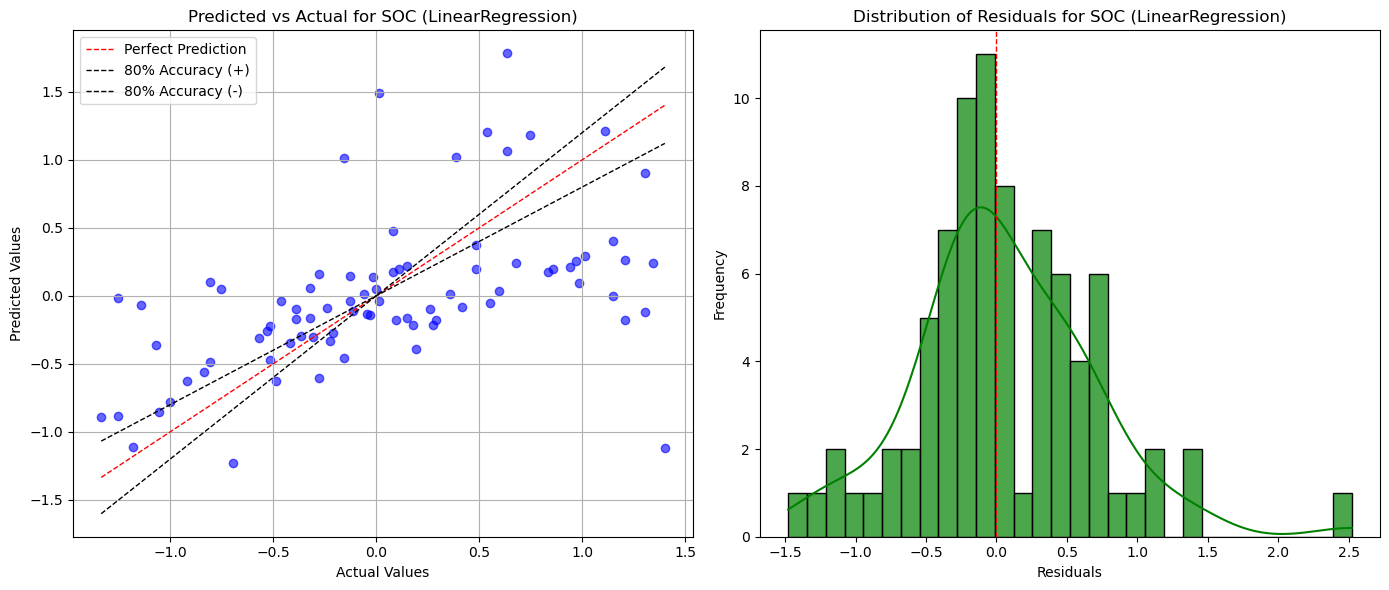

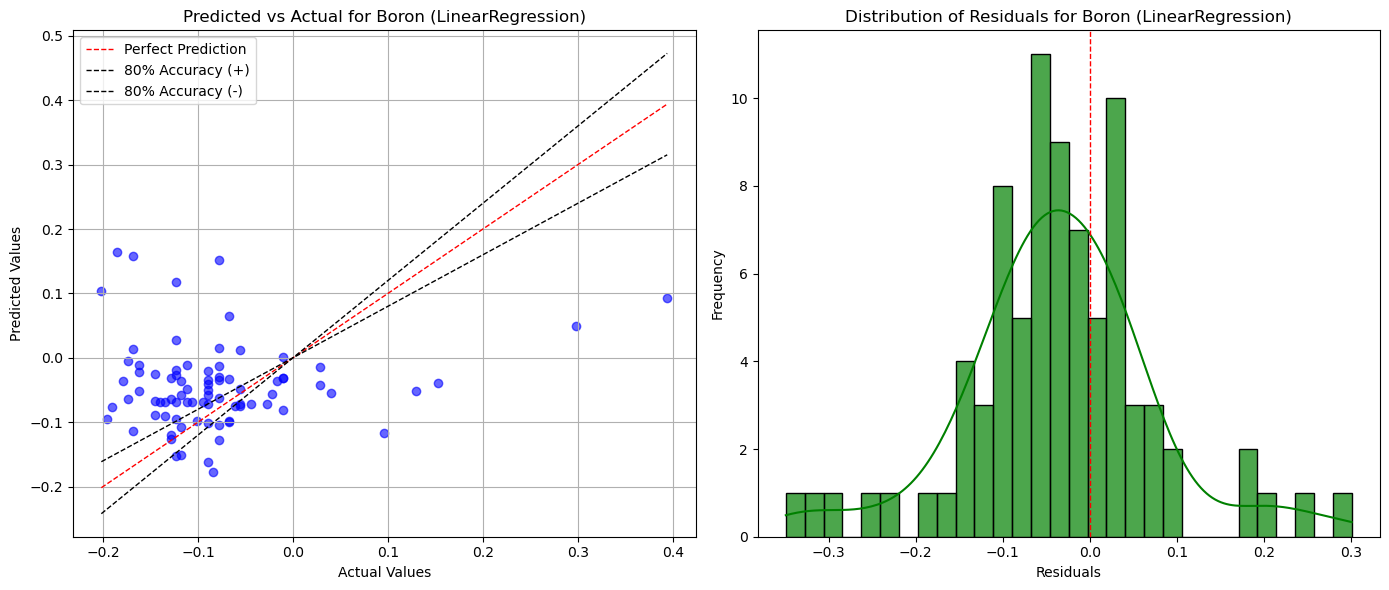

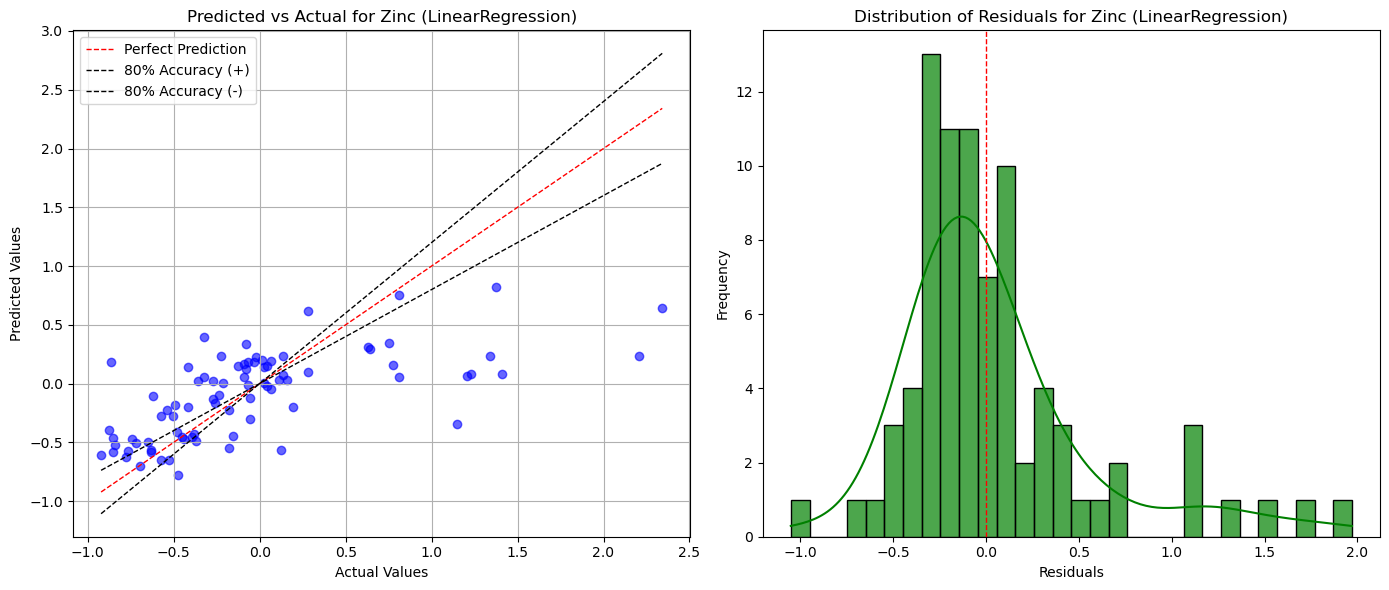

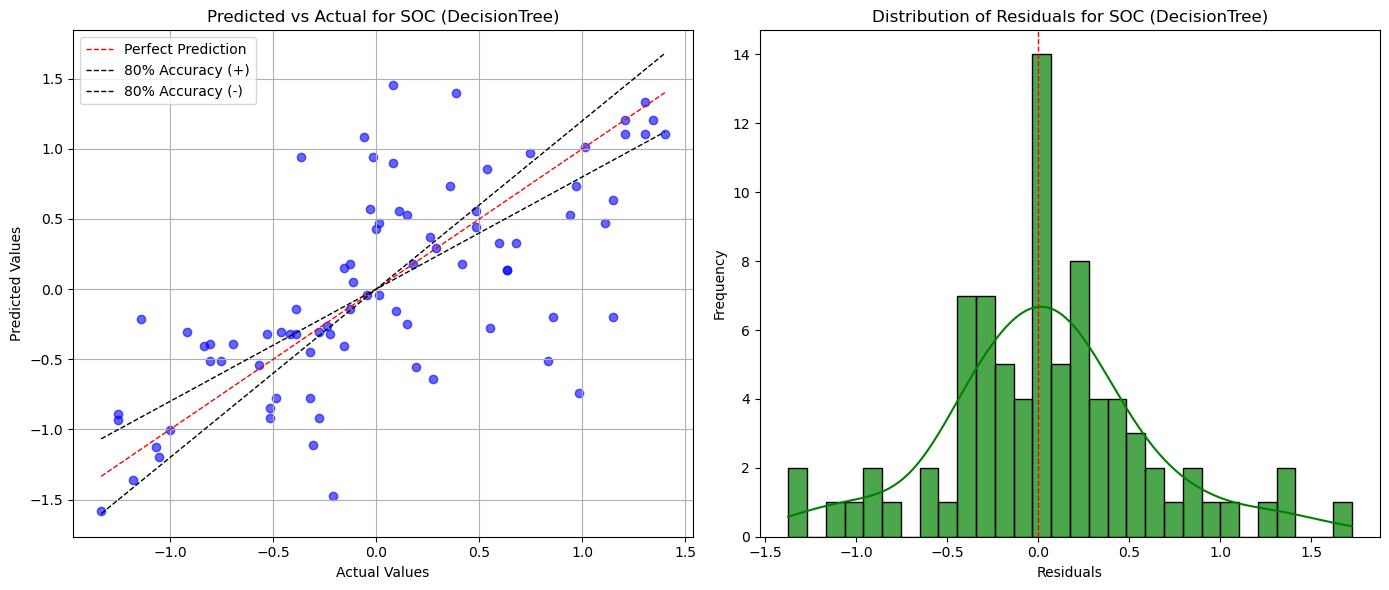

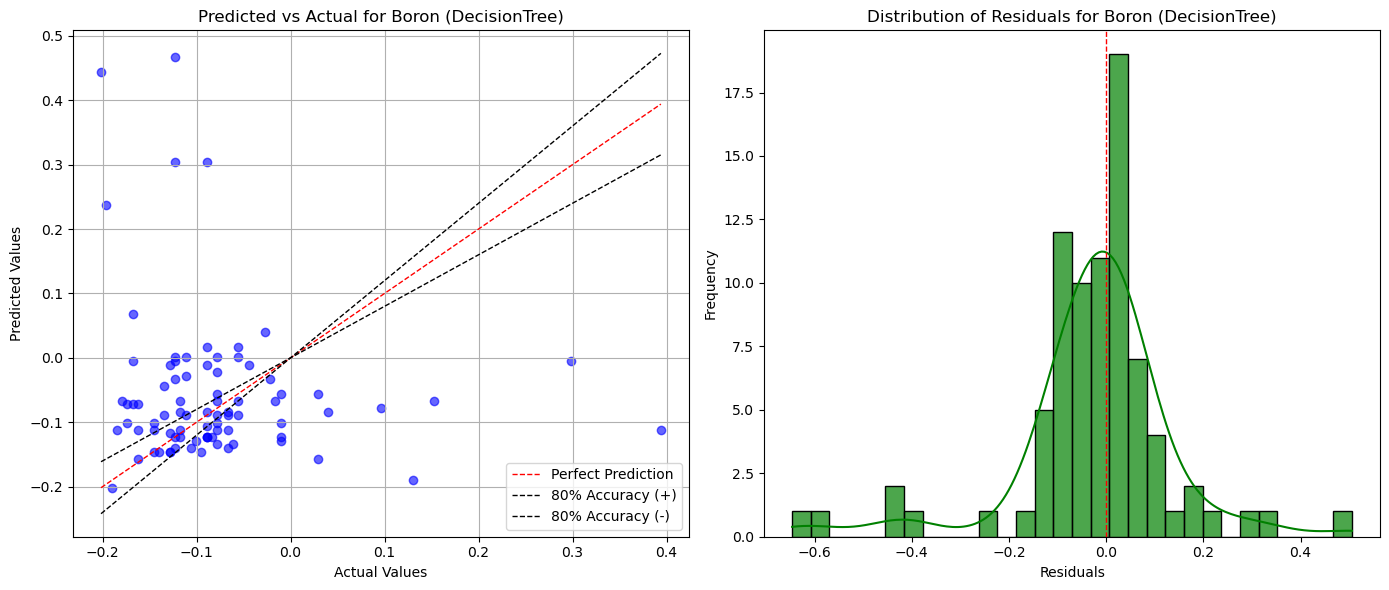

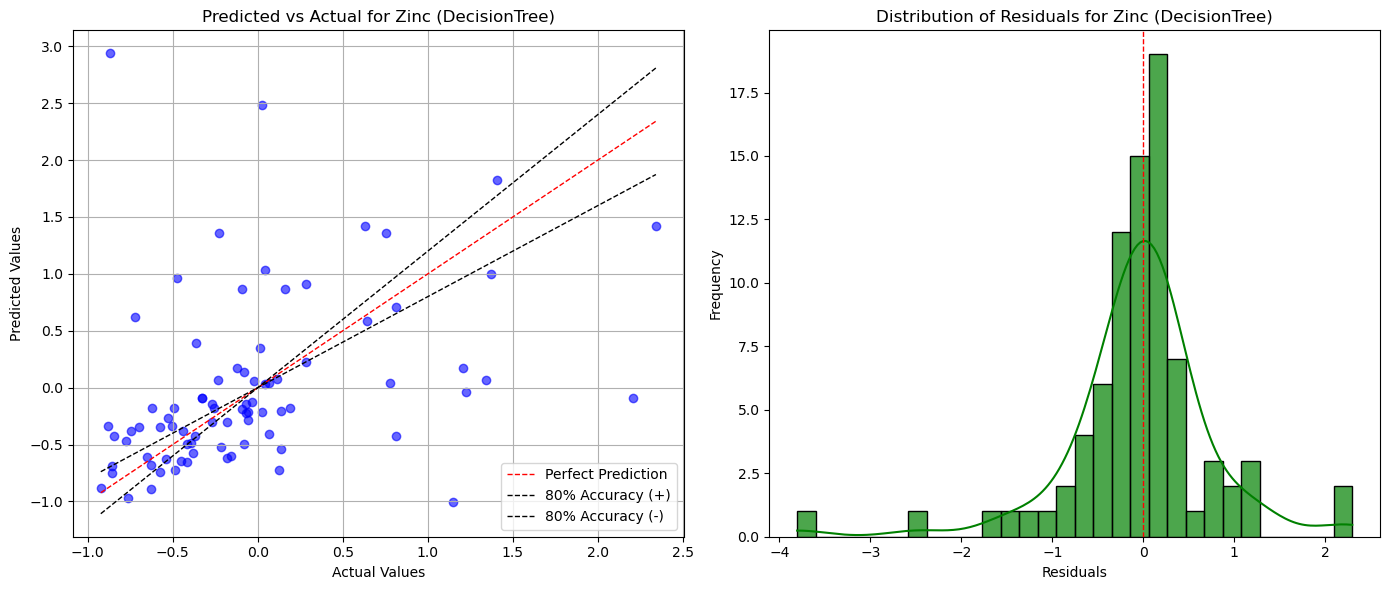

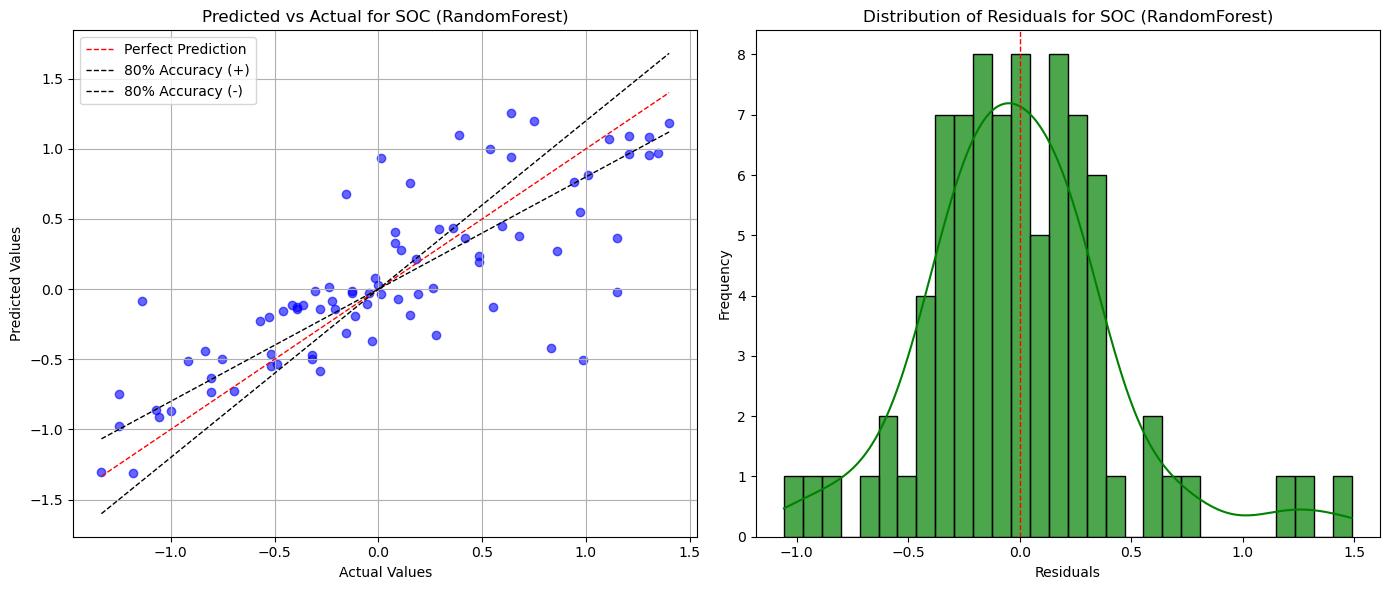

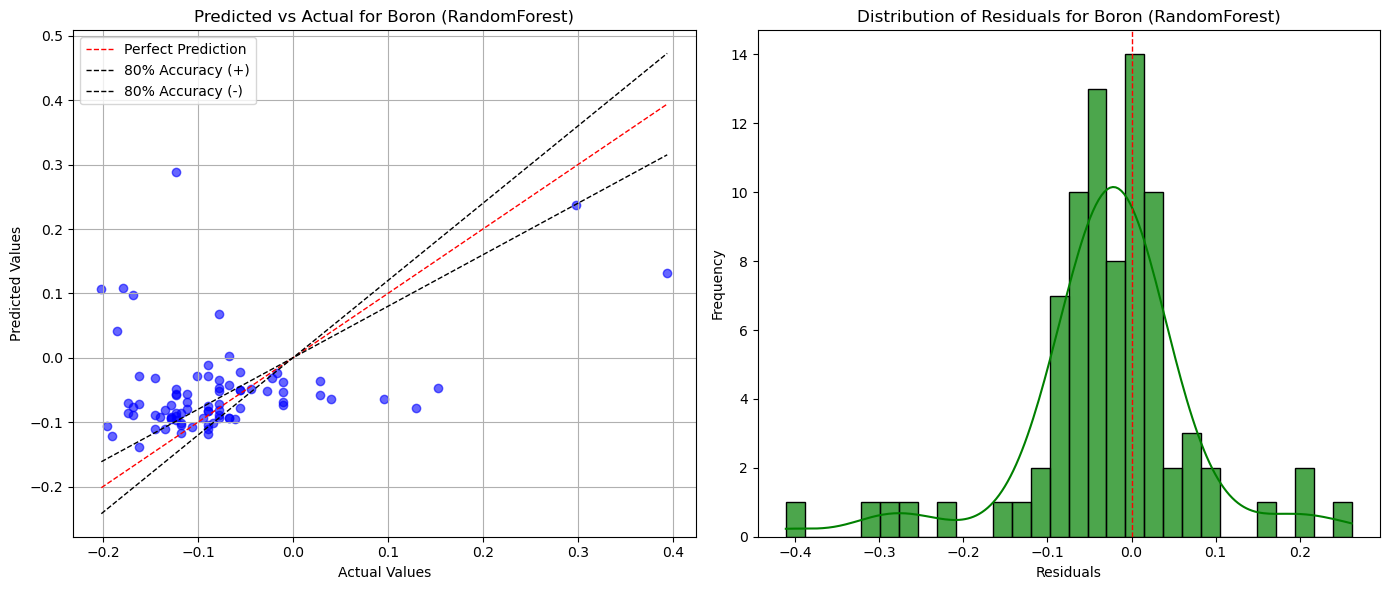

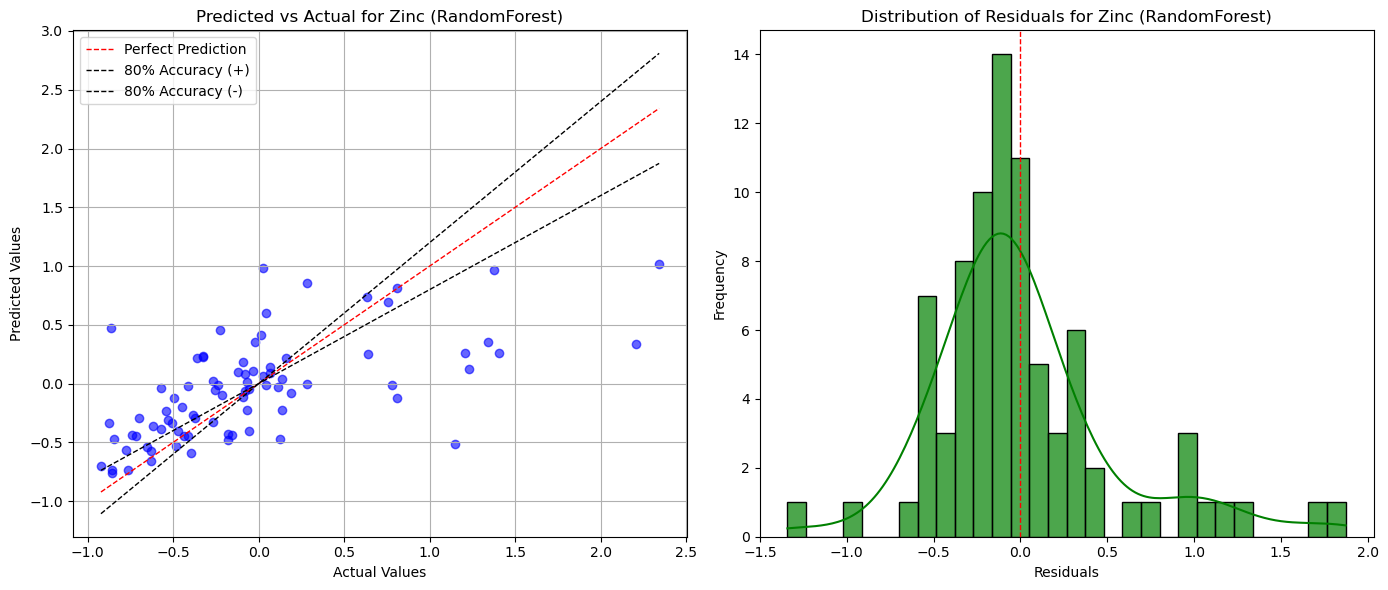

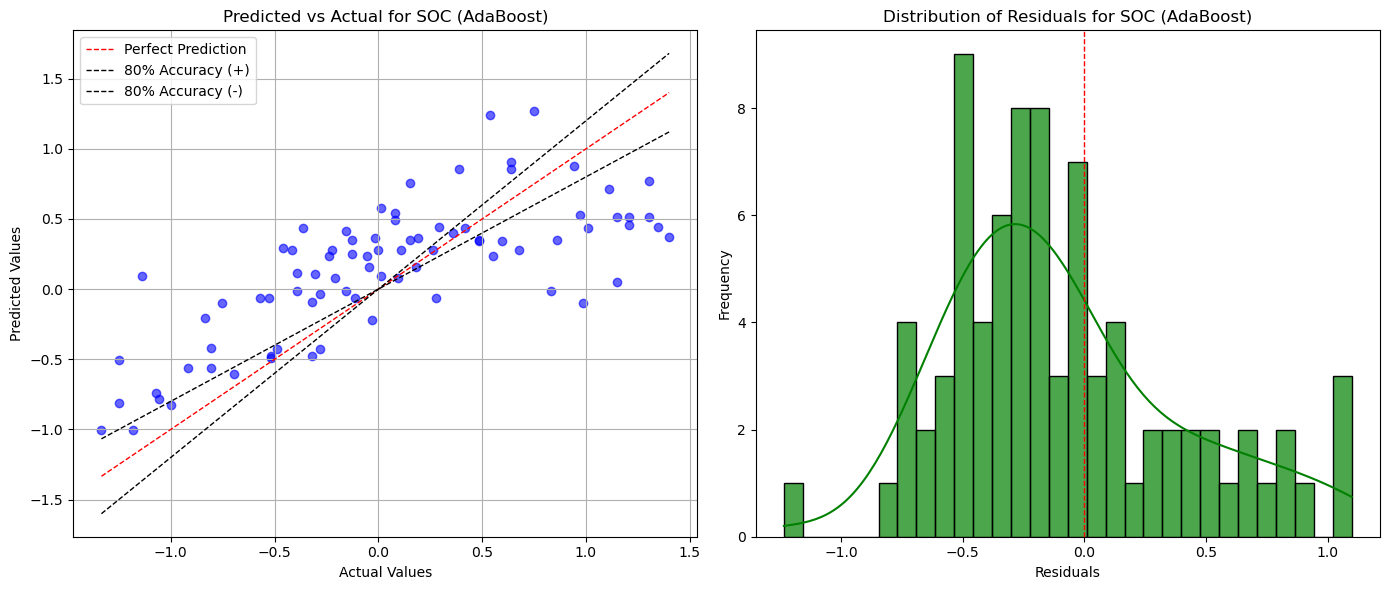

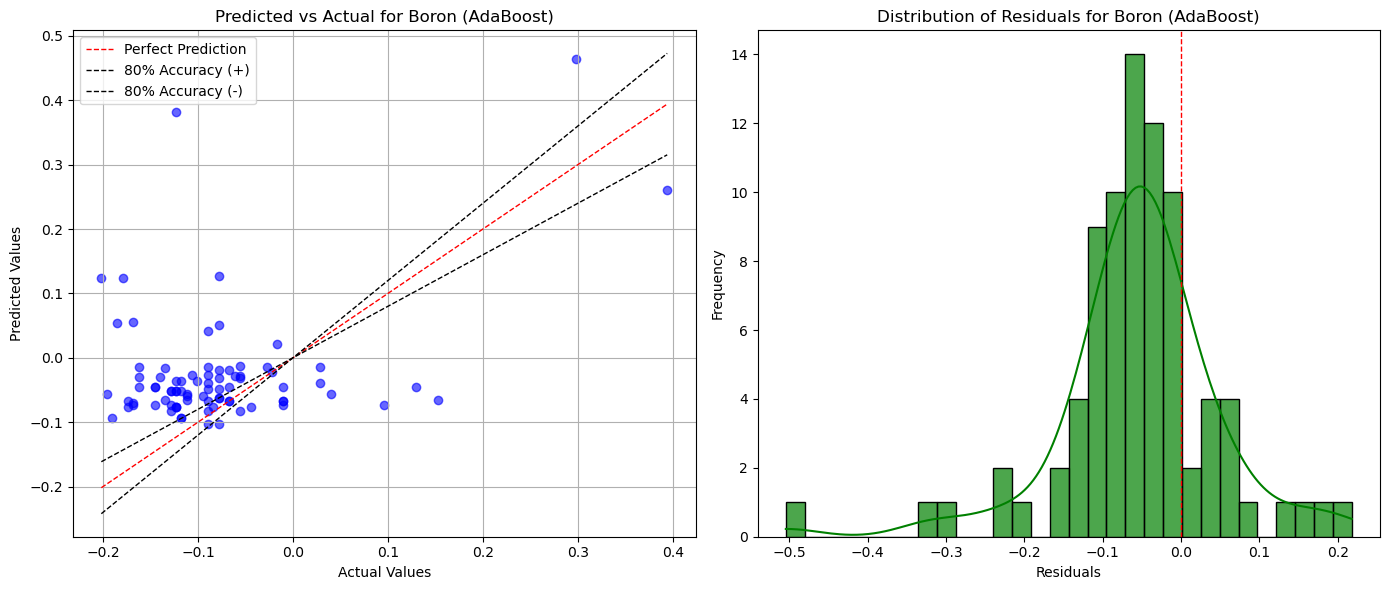

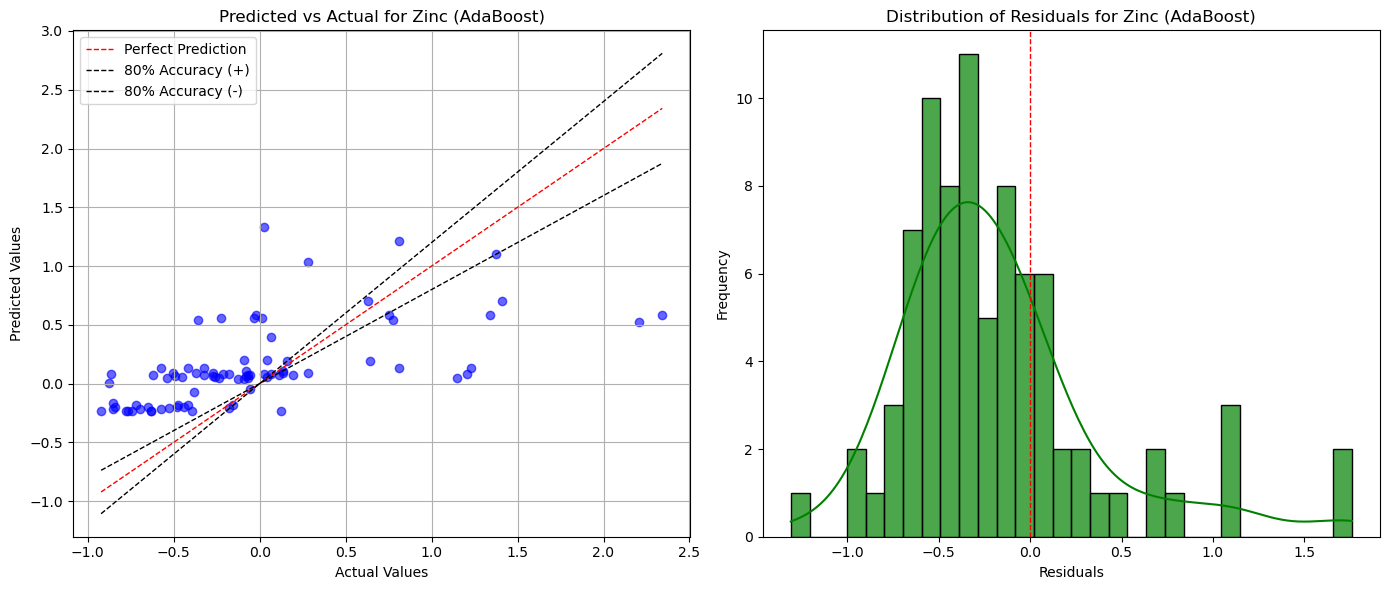

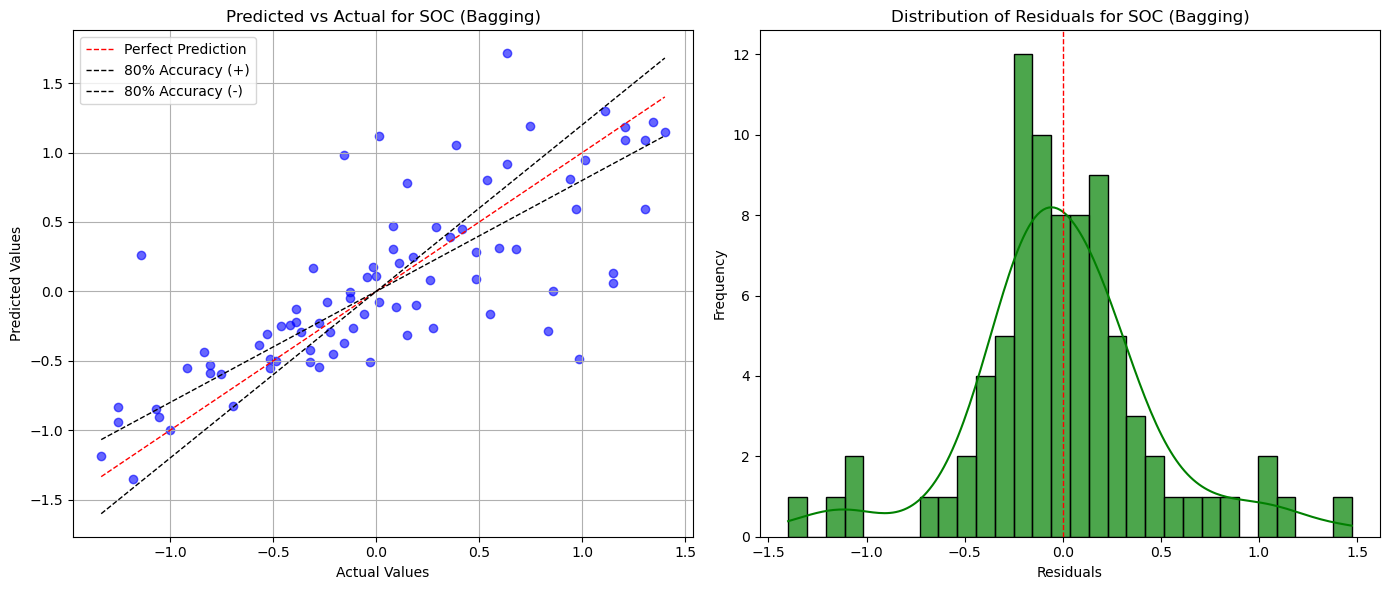

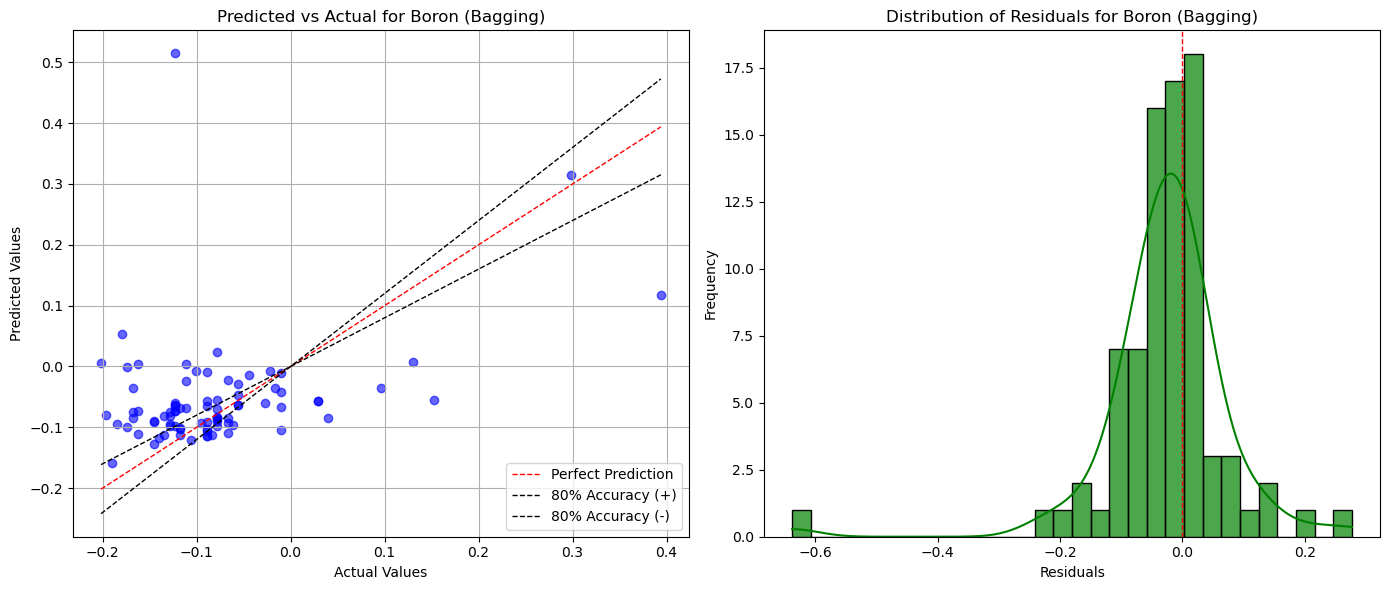

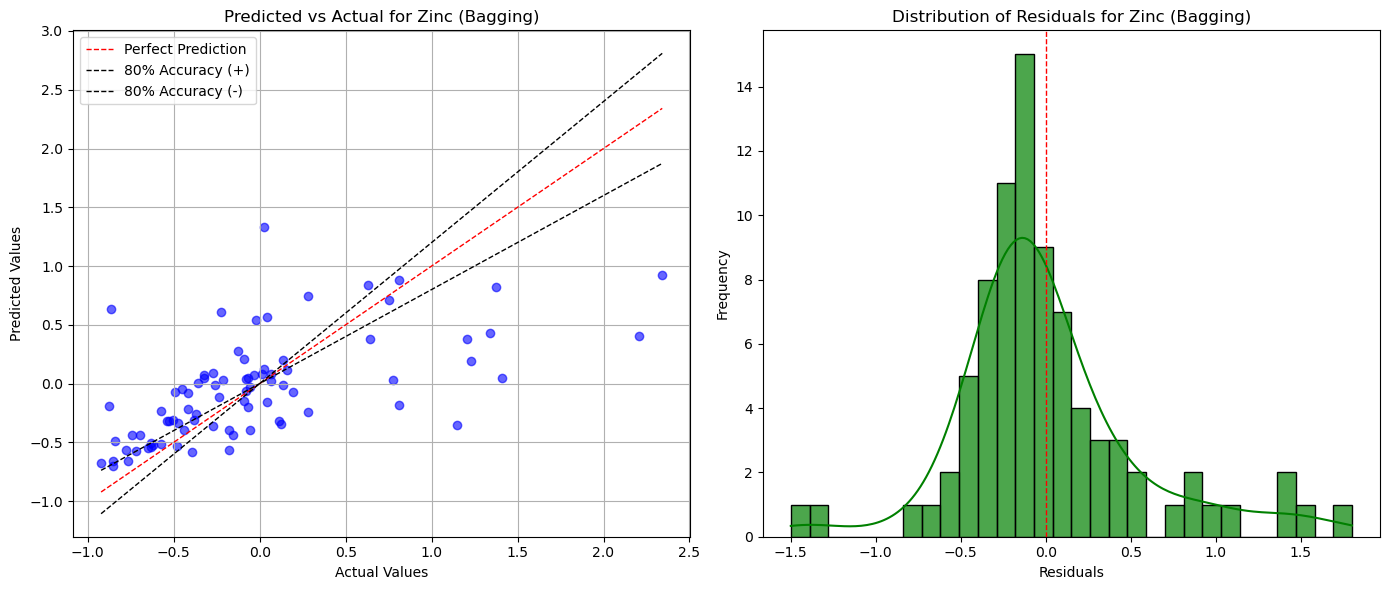

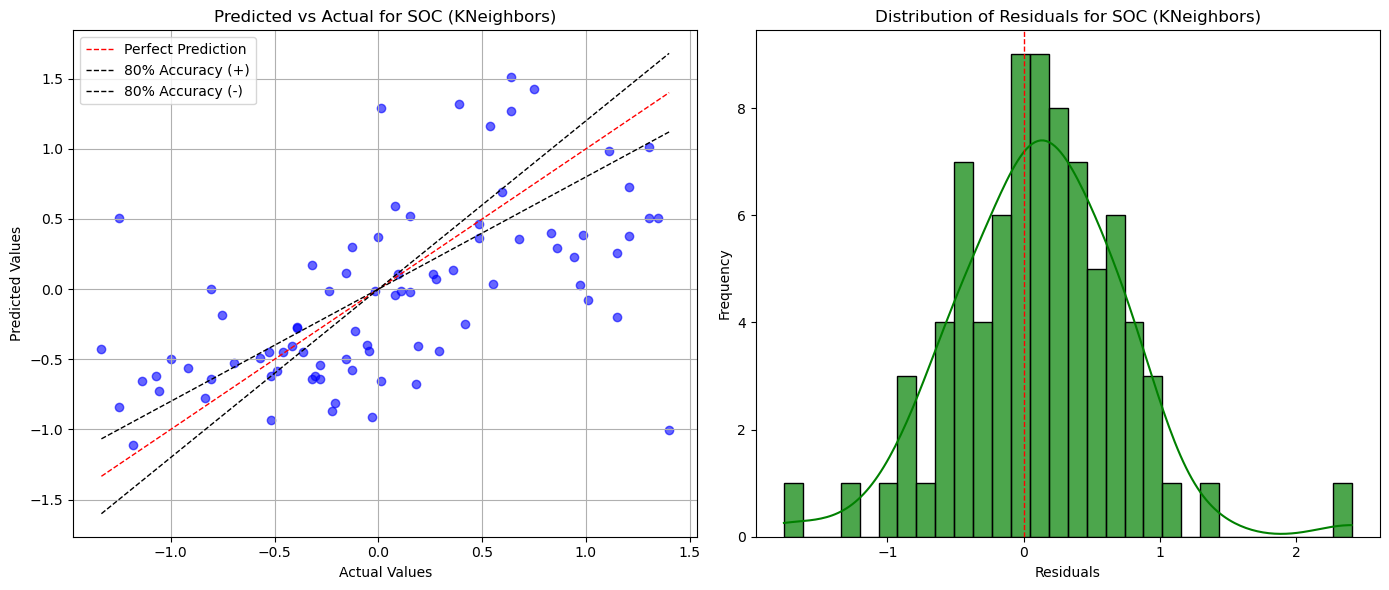

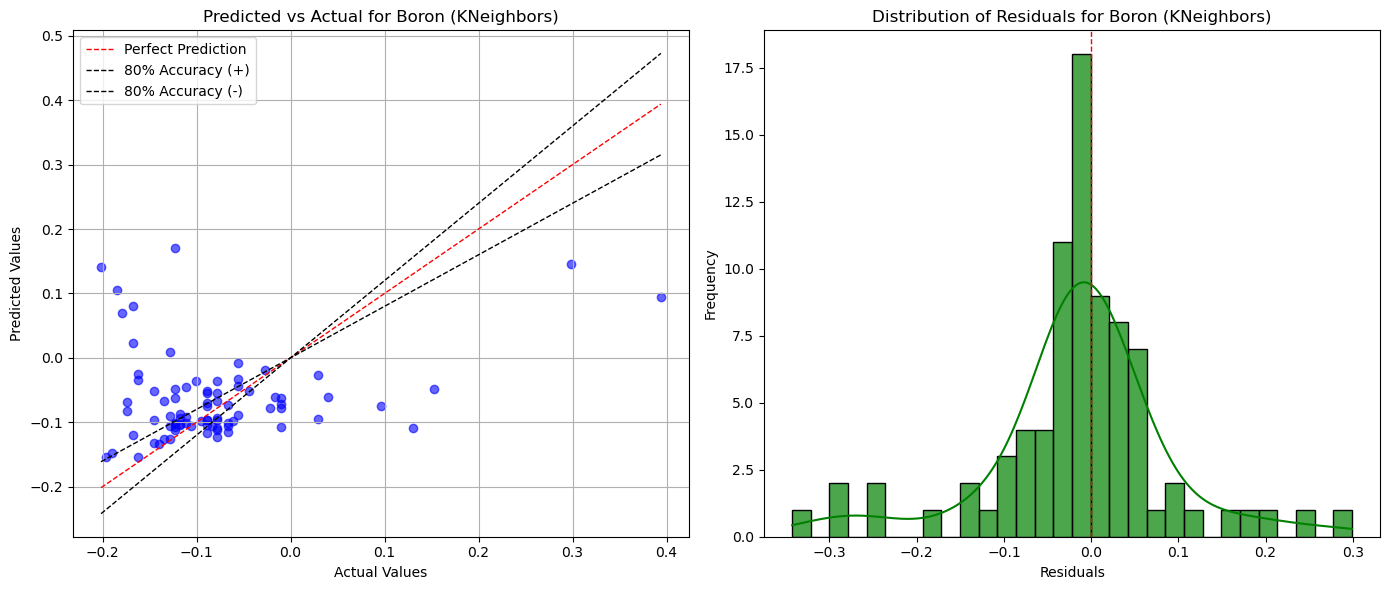

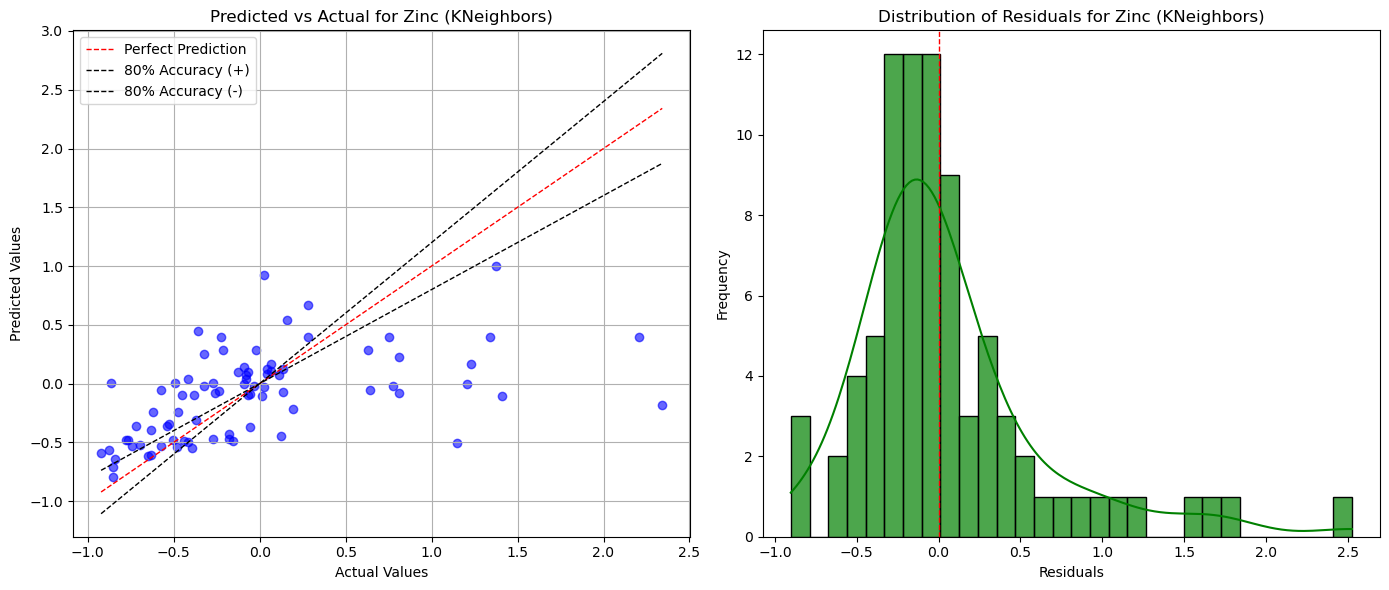

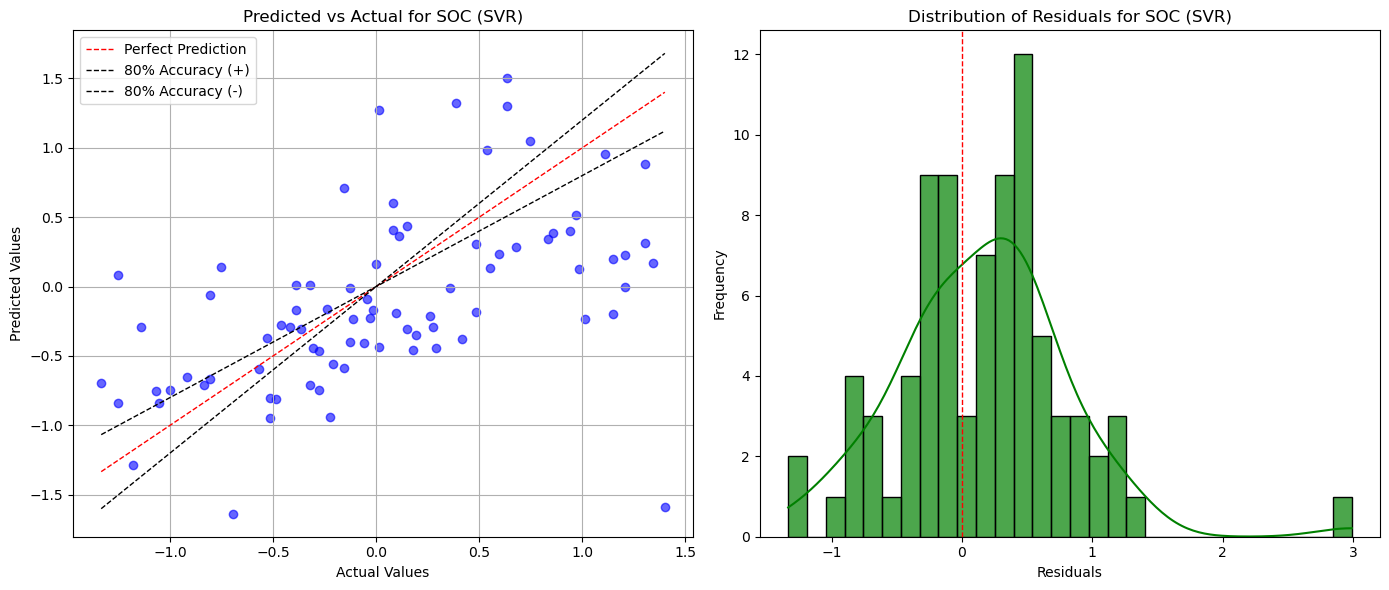

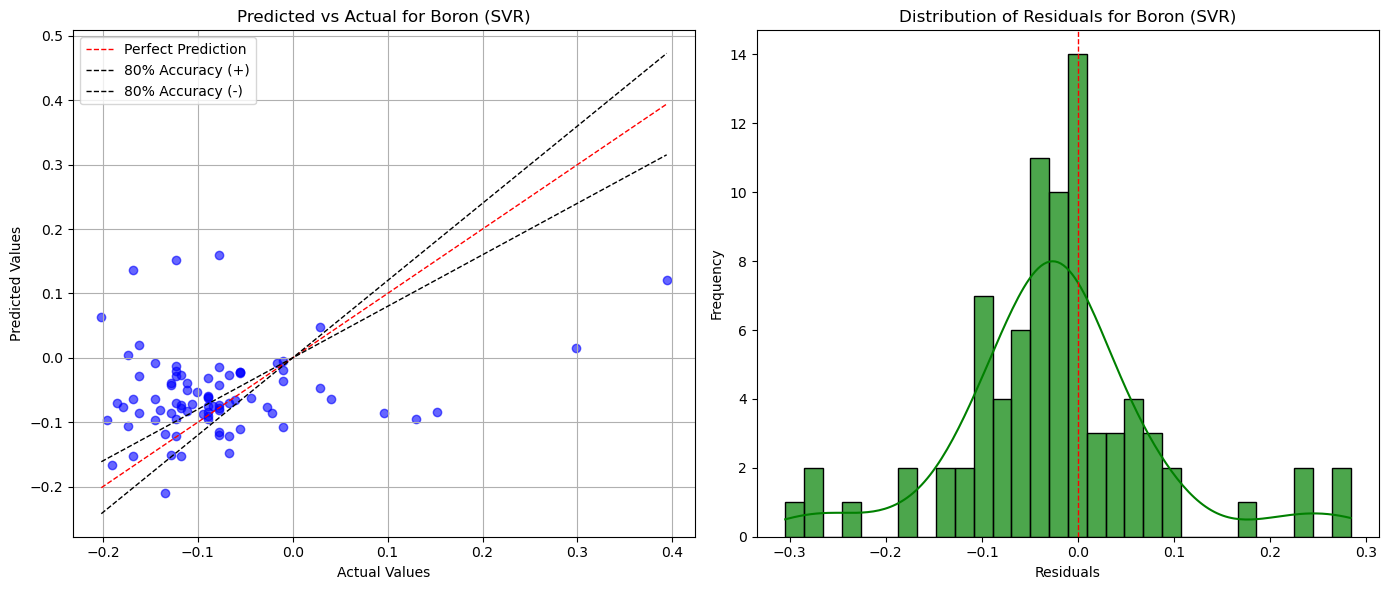

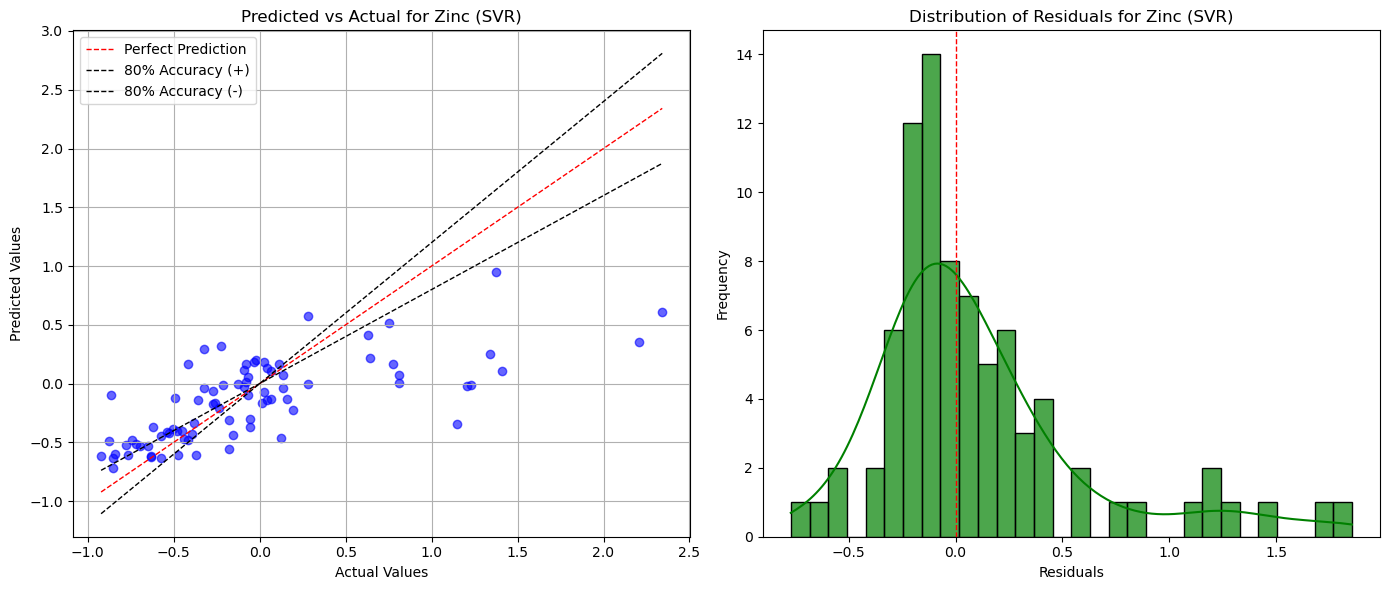

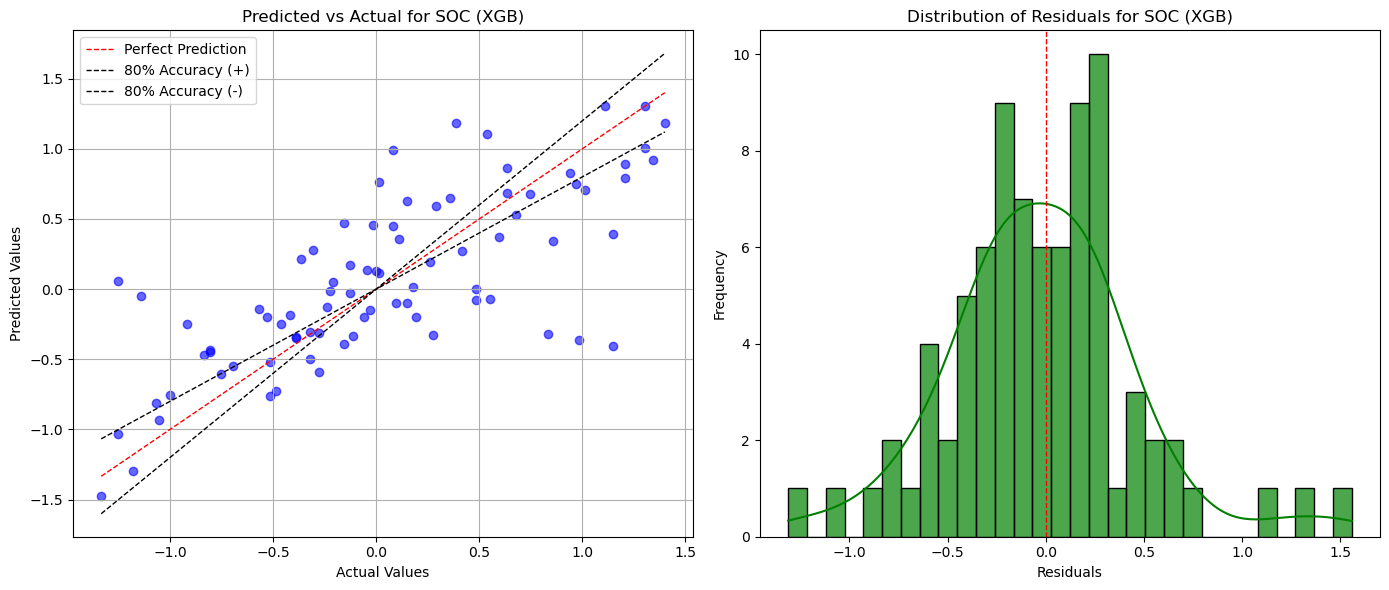

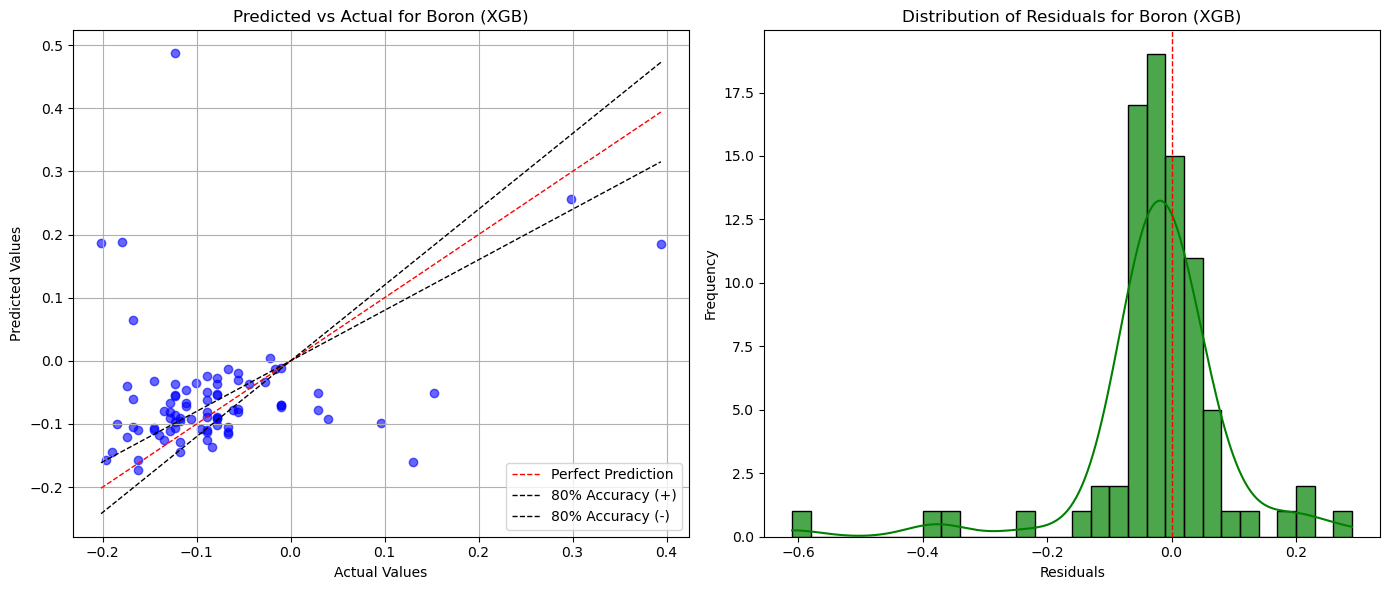

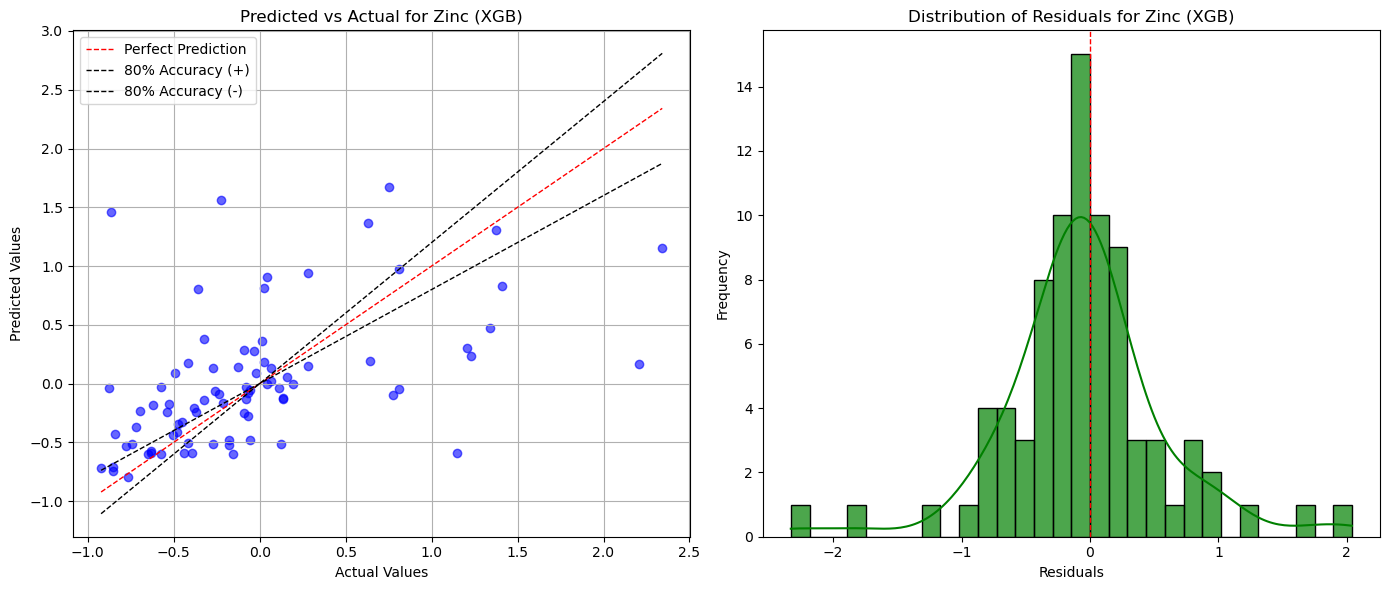

In [16]:
def plot_residuals(y_true, y_pred, target_names, model_name):
    residuals = y_true - y_pred  # Calculate residuals
    
    for idx, target in enumerate(target_names):
        # Create side-by-side plots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Scatter plot of predicted vs actual values
        axes[0].scatter(y_true[:, idx], y_pred[:, idx], alpha=0.6, color='blue')
        
        # Diagonal line for perfect predictions
        min_val, max_val = y_true[:, idx].min(), y_true[:, idx].max()
        axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1, label='Perfect Prediction')
        
        # 80% accuracy lines
        axes[0].plot([min_val, max_val], [min_val * 0.8, max_val * 0.8], color='black', linestyle='--', linewidth=1, label='80% Accuracy (+)')
        axes[0].plot([min_val, max_val], [min_val * 1.2, max_val * 1.2], color='black', linestyle='--', linewidth=1, label='80% Accuracy (-)')
        
        # Plot settings
        axes[0].set_title(f"Predicted vs Actual for {target} ({model_name})")
        axes[0].set_xlabel("Actual Values")
        axes[0].set_ylabel("Predicted Values")
        axes[0].legend()
        axes[0].grid(True)

        # Distribution of residuals
        sns.histplot(residuals[:, idx], kde=True, bins=30, color='green', alpha=0.7, ax=axes[1])
        axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
        axes[1].set_title(f"Distribution of Residuals for {target} ({model_name})")
        axes[1].set_xlabel("Residuals")
        axes[1].set_ylabel("Frequency")

        # Adjust layout and show plots
        plt.tight_layout()
        plt.show()

# Example usage:
for model_name, model in models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)
    residuals = y_test.to_numpy() - y_pred  # Convert y_test to numpy for calculations
    
    # Visualize residuals for each target
    plot_residuals(y_test.to_numpy(), y_pred, target_names, model_name)
